This notebook supports the equations that govern contaminant uptake and impacts on the biology within the Salish Sea Atlantis model. It shows the 1-day output of simulations after injecting PAH components of oil into the water column, to observe biological uptake, as well as non-lethal and lethal impacts relative to a control simulation with no contaminants injected.

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

In [1]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

In [21]:
control_name = '7a_v6699_1000kg_360d_highres_daily_control'
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/"+ control_name + "/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)

In [3]:
time = np.ma.filled(control.variables['t'], np.nan)

In [4]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/')
scenario_paths = sorted([p for p in scenario_root.glob('7a_v6699_1000mgm3_300d_highres_daily/outputSalishSea.nc')])
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]
scenario_paths

[PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/7a_v6699_1000mgm3_300d_highres_daily/outputSalishSea.nc')]

In [5]:
duration_ns = time - time[0]
duration = duration_ns.astype('timedelta64[D]')
duration[1]

numpy.timedelta64(1,'D')

In [6]:
scenario_labels = []
for path in scenario_paths:
    scenario_labels.append(path.parent.stem)

In [7]:
def compare_scenario_pah(species, pah, boxes=groups.salish_sea):
    fig, ax = plt.subplots(figsize = (14,3))
    names = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        names.append(path.parent.stem)
        contam_tbl = np.ma.filled(scenario.variables[species+'_' + pah][:,boxes,:], np.nan)
        volume_tbl = np.ma.filled(scenario.variables['volume'][:,boxes,:], np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)
        ax.plot(duration, contam_mass_t/1e6)
    ax.legend(names)
    ax.set_ylabel(species + ' PAH (kg)')
    ax.set_title(pah, fontsize = 12);

In [8]:
def print_max_pah_conc(species, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        for pah in groups.pahs:
            contam_tbl = np.ma.filled(scenario.variables[species +'_'+ pah], np.nan)
            contam_tb = contam_tbl.sum(axis=2)
            contam_t = contam_tb.sum(axis=1)
            max_contam_mass = contam_t.max()/1e6
            print(path.parent.stem, species, pah, max_contam_mass)

In [9]:
def group_mass(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tbl = np.ma.filled(scenario.variables[variable], np.nan)
            volume_tbl = np.ma.filled(scenario.volume, np.nan)
            time = np.ma.filled(scenario.variables['t'], np.nan)
            contam_mass_tbl = contam_tbl * volume_tbl
            contam_mass_tb = contam_mass_tbl.sum(axis=2)
            contam_mass_t = contam_mass_tb.sum(axis=1)
            ax.plot(time, contam_mass_t/1e6) 
            np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+str(variable)+".csv", contam_mass_t, delimiter = ",")
        ax.legend(group,  loc='best')
        ax.set_ylabel('mass (Kg)')
        ax.set_xlabel('Time')
        ax.set_title(nm)

In [10]:
def group_conc(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tbl = np.ma.filled(scenario.variables[variable], np.nan)
            time = np.ma.filled(scenario.variables['t'], np.nan)
            contam_tb = contam_tbl.sum(axis=2)
            contam_t = contam_tb.sum(axis=1)
            ax.plot(time, contam_t) #zoom into recruitement of Chinook [40:60]
            np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+str(variable)+".csv", contam_t, delimiter = ",")
        ax.legend(group,  loc='best')
        ax.set_ylabel('Concentration (mg/m$^3$)')
        ax.set_xlabel('Time')
        ax.set_title(nm)

In [11]:
def group_conc_benthic(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tb = np.ma.filled(scenario.variables[variable], np.nan)
            time = np.ma.filled(scenario.variables['t'], np.nan)
            contam_t = contam_tb.sum(axis=1)
            np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+str(variable)+".csv", contam_t, delimiter = ",")
            ax.plot(time, contam_t) #zoom into recruitement of Chinook [40:60]
        ax.legend(group,  loc='best')
        ax.set_ylabel('Concentration (mg/m$^2$)')
        ax.set_xlabel('Time')
        ax.set_title(nm)

### Water Column - without resets

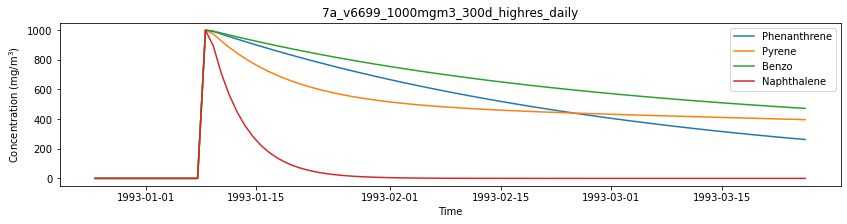

In [12]:
group_conc(groups.pahs, scenario_datasets, scenario_paths)


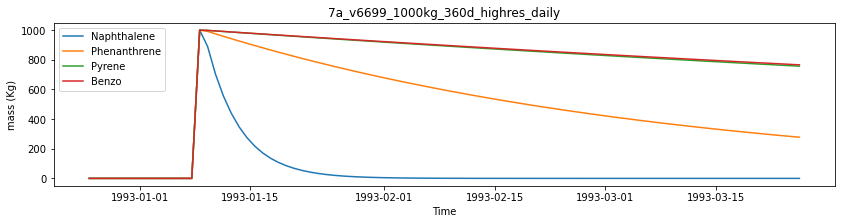

In [13]:
splot.group_mass(groups.pahs, scenario_datasets, scenario_paths)

In [14]:
for scenario in scenario_datasets:
    contam_t = np.ma.filled(scenario.variables['Naphthalene'][:,1,5], np.nan)

In [15]:
num = 13
print('Concentration (mg/m3) of contaminants released in Box 1 on '+str(time[num])+' is '+str(contam_t[num]))

Concentration (mg/m3) of contaminants released in Box 1 on 1993-01-07T14:00:00.000000000 is 0.0


In [16]:
num = 14
print('Concentration (mg/m3) of contaminants released in Box 1 on '+str(time[num])+' is '+str(contam_t[num]))

Concentration (mg/m3) of contaminants released in Box 1 on 1993-01-08T14:00:00.000000000 is 0.060263202450966


### Biology

#### Lower trophic levels

Uptake rates for contaminants in diatoms (PL)
- Diatom_Naphthalene_uptake_rate    = 0.001
- Diatom_Phenanthrene_uptake_rate   = 0.001
- Diatom_Pyrene_uptake_rate         = 0.050
- Diatom_Benzo_uptake_rate          = 0.010

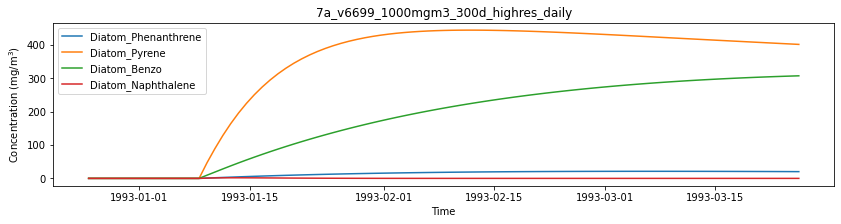

In [13]:
new_group = {}
for pah in groups.pahs:
    new_group['Diatom_'+pah]= 'Diatom_' +pah
group_conc(new_group, scenario_datasets, scenario_paths)

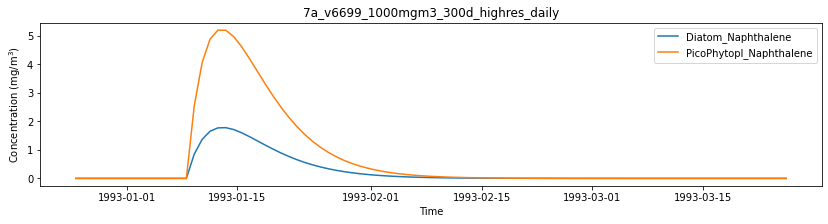

In [15]:
new_group = {}
for species in groups.phytoplankton:
    new_group[groups.phytoplankton[species]+'_Naphthalene']= species+'_Naphthalene'
group_conc(new_group, scenario_datasets, scenario_paths)

Uptake rates for contaminants in picophytoplankton (PS)
- Picos_Naphthalene_uptake_rate    = 0.00300
- Pico_Phenanthrene_uptake_rate   = 0.00020
- Diatom_Pyrene_uptake_rate         = 0.00014
- Diatom_Benzo_uptake_rate          = 0.00008

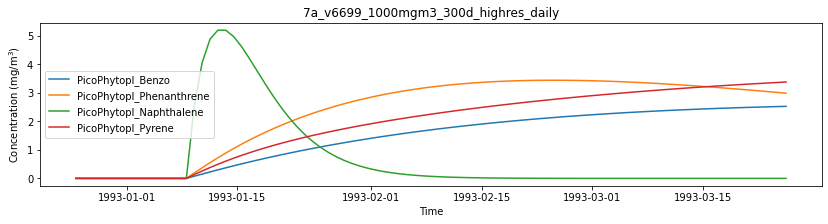

In [12]:
new_group = {}
for pah in groups.pahs:
    new_group['PicoPhytopl_'+pah]= 'PicoPhytopl_' +pah
group_conc(new_group, scenario_datasets, scenario_paths)

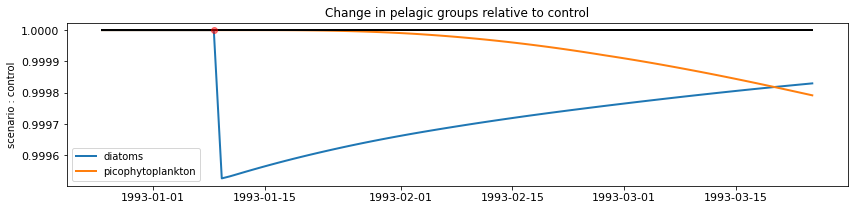

In [16]:
start = 0
end = time.size-1
for scenario in scenario_datasets:
    splot.compare_groups_pelagic(groups.phytoplankton, scenario, control, time, start, end, groups.salish_sea, time[14])

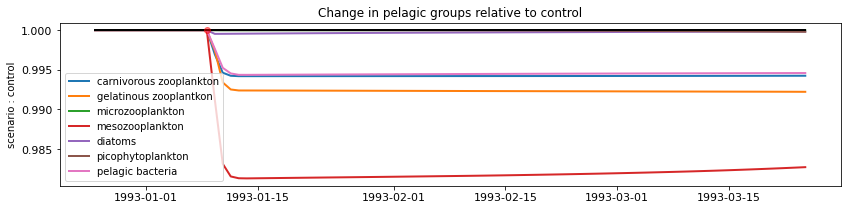

In [17]:
start = 0
end = time.size-1
for scenario in scenario_datasets:
    splot.compare_groups_pelagic(groups.plankton, scenario, control, time, start, end, groups.salish_sea, time[14])

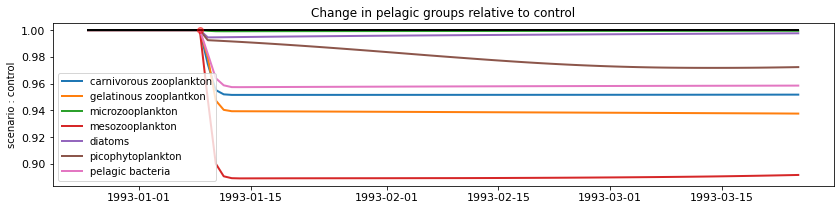

In [63]:
start = 0
end = time.size-1
for scenario in scenario_datasets:
    splot.compare_groups_pelagic(groups.plankton, scenario, control, time, start, end, groups.juan_de_fuca, time[14])

Calculate mean change in biomass for last 5 years of the simulation for plankton

In [28]:
box = 1
mean_start = end-10
species_index = {}
for scenario in scenario_datasets:
    for group in groups.plankton:
        scenario_tl = np.ma.filled(scenario.variables[groups.plankton[group]+'_N'][mean_start:end,box,0:6], np.nan)
        control_tl = np.ma.filled(control.variables[groups.plankton[group]+'_N'][mean_start:end,box,0:6], np.nan)
        scenario_t = scenario_tl.sum(axis=1)
        control_t = control_tl.sum(axis=1)
        biomass_change_percent = scenario_t.sum()/control_t.sum() #(-1)*100
        species_index[groups.plankton[group]] = biomass_change_percent
species_index

{'Carniv_Zoo': 7.851593243521784e-09,
 'Gelat_Zoo': 8.915603611630267e-10,
 'MicroZoo': 6.180584057151648e-05,
 'Zoo': 2.8270253054032504e-10,
 'Diatom': 0.14825765964368506,
 'PicoPhytopl': 0.0027807677263858312,
 'Pelag_Bact': 0.37690372573074044}

In [94]:
boxes = groups.salish_sea
mean_start = end-11
biomass_change = []
bio_group = groups.plankton
for scenario in scenario_datasets:
    for group in bio_group:
        scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
        control_tbl = np.ma.filled(control.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
        scenario_tb = scenario_tbl.mean(axis=2)
        control_tb = control_tbl.mean(axis=2)
        scenario_t = scenario_tb.mean(axis=1)
        control_t = control_tb.mean(axis=1)
        biomass_change.append((scenario_t.mean()/control_t.mean()-1)*100)
salish_sea_change = biomass_change
salish_sea_change

[-0.5755579298712843,
 -0.7759399570624215,
 -8.977087208039691e-05,
 -1.7479102926979406,
 -0.018157534440510492,
 -0.018026139730531465,
 -0.5417775469345187]

In [95]:
boxes = groups.juan_de_fuca
mean_start = end-11
biomass_change = []
for scenario in scenario_datasets:
    for group in groups.plankton:
        scenario_tbl = np.ma.filled(scenario.variables[groups.plankton[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
        control_tbl = np.ma.filled(control.variables[groups.plankton[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
        scenario_tb = scenario_tbl.mean(axis=2)
        control_tb = control_tbl.mean(axis=2)
        scenario_t = scenario_tb.mean(axis=1)
        control_t = control_tb.mean(axis=1)
        biomass_change.append((scenario_t.mean()/control_t.mean()-1)*100)
juan_de_fuca_change = biomass_change
juan_de_fuca_change

[-4.826926780041962,
 -6.226978885156886,
 -0.05326576877043854,
 -10.889117630462097,
 -0.2502578643343356,
 -2.7979946703444836,
 -4.154742525551414]

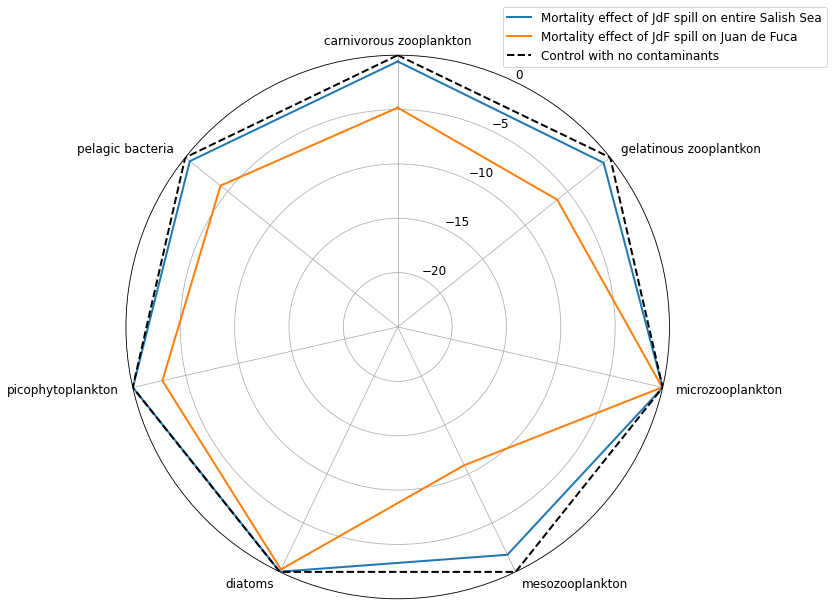

In [96]:
label_size = 11
font_size = 12
line_width = 2
indicators = groups.plankton
num_vars = len(indicators)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
salish_sea_change += salish_sea_change[:1]
juan_de_fuca_change += juan_de_fuca_change[:1]
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.plot(angles, salish_sea_change, linewidth=line_width, label='Mortality effect of JdF spill on entire Salish Sea')
ax.plot(angles, juan_de_fuca_change, linewidth=line_width, label='Mortality effect of JdF spill on Juan de Fuca')
ax.plot(angles, np.zeros(num_vars+1), 'k--',linewidth=line_width, label='Control with no contaminants')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(180 / num_vars)
ax.set_ylim(-25, 0)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(indicators)
ax.tick_params(axis='x', labelsize=font_size)
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=font_size);

#### Higher trophic levels

- Biomass = mgN/m3 (XXX_N)
- Growth = structural N / individual of a oldest cohort (XXX_StructN/XXX_Nums)
- Reproduction = numbers of cohort 1 (XX1_Nums)

In [111]:
boxes = groups.salish_sea
mean_start = end-11
bio_group = groups.named_fish

In [143]:

def plot_radar_biomass_growth_reprod(bio_group, boxes, mean_start, end):
    for scenario in scenario_datasets:
        biomass_change = []
        for group in bio_group:
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
            control_tbl = np.ma.filled(control.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
            scenario_tb = scenario_tbl.mean(axis=2)
            control_tb = control_tbl.mean(axis=2)
            scenario_t = scenario_tb.mean(axis=1)
            control_t = control_tb.mean(axis=1)
            biomass_change.append((scenario_t.mean()/control_t.mean()-1)*100)
        biomass_change += biomass_change[:1]

        growth_change = []
        for group in bio_group:
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_StructN'][mean_start:end,boxes,0:6], np.nan)
            scenario_nums_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_Nums'][mean_start:end,boxes,0:6], np.nan)
            control_tbl = np.ma.filled(control.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_StructN'][mean_start:end,boxes,0:6], np.nan)
            control_nums_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_Nums'][mean_start:end,boxes,0:6], np.nan)
            scenario_growth_tbl = scenario_tbl * (1/(scenario_nums_tbl+(scenario_nums_tbl==0)))
            control_growth_tbl = control_tbl * (1/(control_nums_tbl+(control_nums_tbl==0)))
            scenario_growth_tb = scenario_growth_tbl.mean(axis=2)
            control_growth_tb = control_growth_tbl.mean(axis=2)
            scenario_growth_t = scenario_growth_tb.mean(axis=1)
            control_growth_t = control_growth_tb.mean(axis=1)
            growth_change.append((scenario_growth_t.mean()/control_growth_t.mean()-1)*100)
        growth_change += growth_change[:1]

        reprod_change = []
        for group in bio_group:
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+'1_Nums'][mean_start:end,boxes,0:6], np.nan)
            control_tbl = np.ma.filled(control.variables[bio_group[group]+'1_Nums'][mean_start:end,boxes,0:6], np.nan)
            scenario_tb = scenario_tbl.mean(axis=2)
            control_tb = control_tbl.mean(axis=2)
            scenario_t = scenario_tb.mean(axis=1)
            control_t = control_tb.mean(axis=1)
            reprod_change.append((scenario_t.mean()/control_t.mean()-1)*100)
        reprod_change += reprod_change[:1]

        data_values = {'Contaminant effect on biomass':biomass_change,'Contaminant effect on growth':growth_change,'Contaminant effect on reproduction':reprod_change}
        num_vars = len(bio_group)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
        for item in data_values:
            ax.plot(angles, data_values[item], linewidth=line_width, label=item)
        ax.plot(angles, np.zeros(num_vars+1), 'k--',linewidth=line_width, label='Control, no contaminants')
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(180 / num_vars)
        ax.set_ylim(-5, 0)
        ax.tick_params(axis='y', labelsize=font_size)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(bio_group)
        ax.tick_params(axis='x', labelsize=font_size)
        for label, angle in zip(ax.get_xticklabels(), angles):
            if angle in (0, np.pi):
                label.set_horizontalalignment('center')
            elif 0 < angle < np.pi:
                label.set_horizontalalignment('left')
            else:
                label.set_horizontalalignment('right')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=font_size);

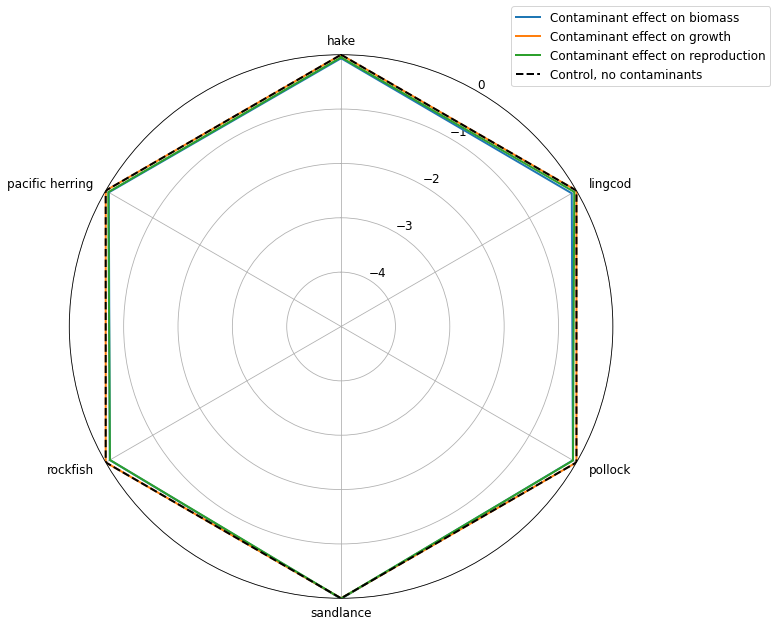

In [144]:
plot_radar_biomass_growth_reprod(bio_group, boxes, mean_start, end)

In [ ]:
biomass_change = []
for scenario in scenario_datasets:
    for group in bio_group:
        scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
        control_tbl = np.ma.filled(control.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
        scenario_tb = scenario_tbl.mean(axis=2)
        control_tb = control_tbl.mean(axis=2)
        scenario_t = scenario_tb.mean(axis=1)
        control_t = control_tb.mean(axis=1)
        biomass_change.append((scenario_t.mean()/control_t.mean()-1)*100)
biomass_change += biomass_change[:1]
biomass_change

[-0.0653898323036195,
 -0.10013745214030312,
 -0.07558596888358471,
 0.009179601144038152,
 -0.0875288791160389,
 -0.06568847734944594,
 -0.0653898323036195]

In [122]:
growth_change = []
for scenario in scenario_datasets:
    for group in bio_group:
        scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_StructN'][mean_start:end,boxes,0:6], np.nan)
        scenario_nums_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_Nums'][mean_start:end,boxes,0:6], np.nan)
        control_tbl = np.ma.filled(control.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_StructN'][mean_start:end,boxes,0:6], np.nan)
        control_nums_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_Nums'][mean_start:end,boxes,0:6], np.nan)
        scenario_growth_tbl = scenario_tbl * (1/(scenario_nums_tbl+(scenario_nums_tbl==0)))
        control_growth_tbl = control_tbl * (1/(control_nums_tbl+(control_nums_tbl==0)))
        scenario_growth_tb = scenario_growth_tbl.mean(axis=2)
        control_growth_tb = control_growth_tbl.mean(axis=2)
        scenario_growth_t = scenario_growth_tb.mean(axis=1)
        control_growth_t = control_growth_tb.mean(axis=1)
        growth_change.append((scenario_growth_t.mean()/control_growth_t.mean()-1)*100)
growth_change += growth_change[:1]
growth_change

[-0.0015739985519513944,
 -6.698087623435711e-05,
 5.773159728050814e-13,
 -1.354472090042691e-12,
 -6.367481705238376e-05,
 -0.0002950818809410727,
 -0.0015739985519513944]

In [119]:
reprod_change = []
for scenario in scenario_datasets:
    for group in bio_group:
        scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+'1_Nums'][mean_start:end,boxes,0:6], np.nan)
        control_tbl = np.ma.filled(control.variables[bio_group[group]+'1_Nums'][mean_start:end,boxes,0:6], np.nan)
        scenario_tb = scenario_tbl.mean(axis=2)
        control_tb = control_tbl.mean(axis=2)
        scenario_t = scenario_tb.mean(axis=1)
        control_t = control_tb.mean(axis=1)
        reprod_change.append((scenario_t.mean()/control_t.mean()-1)*100)
reprod_change += reprod_change[:1]
reprod_change

[-0.049097541917364484,
 -0.047540283718250365,
 -0.07264154613932927,
 0.002256955384494219,
 -0.090032504782811,
 -0.055059071939578264,
 -0.049097541917364484]

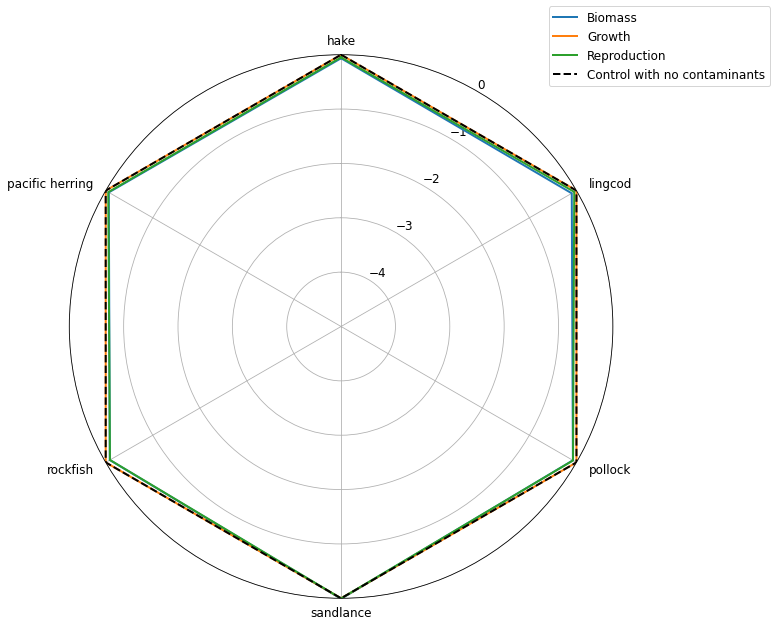

In [126]:
data_values = {'Biomass':biomass_change,'Growth':growth_change,'Reproduction':reprod_change}
num_vars = len(bio_group)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
for item in data_values:
  ax.plot(angles, data_values[item], linewidth=line_width, label=item)
ax.plot(angles, np.zeros(num_vars+1), 'k--',linewidth=line_width, label='Control with no contaminants')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(180 / num_vars)
ax.set_ylim(-5, 0)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(bio_group)
ax.tick_params(axis='x', labelsize=font_size)
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=font_size);

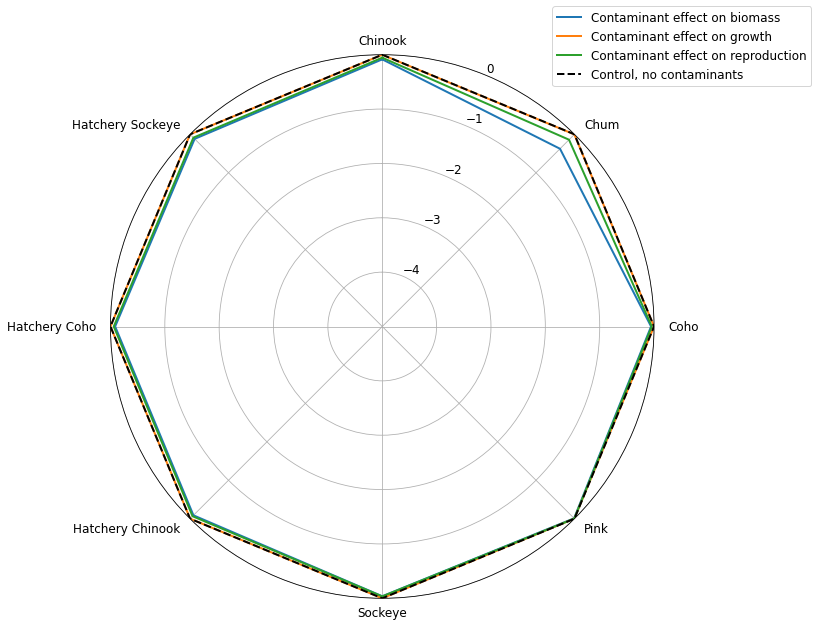

In [145]:
plot_radar_biomass_growth_reprod(groups.salmon, boxes, mean_start, end)

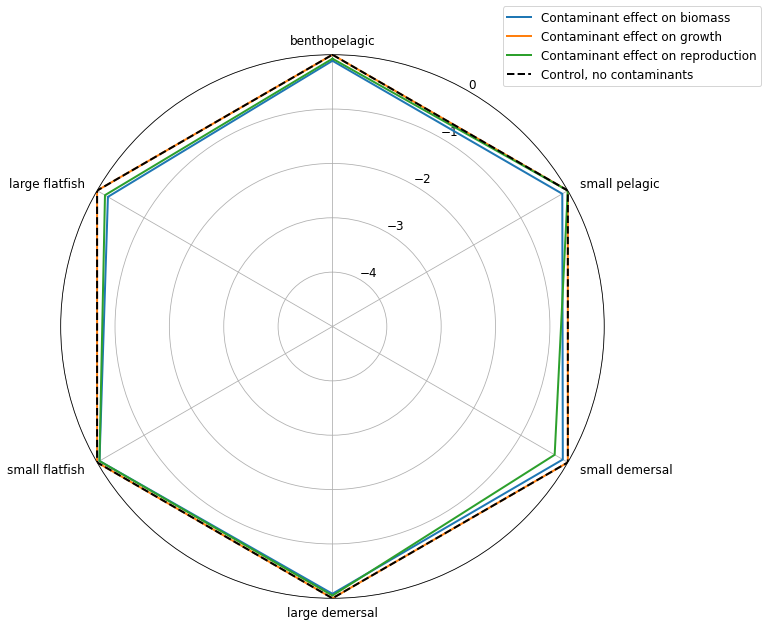

In [149]:
plot_radar_biomass_growth_reprod(groups.other_fish, boxes, mean_start, end)

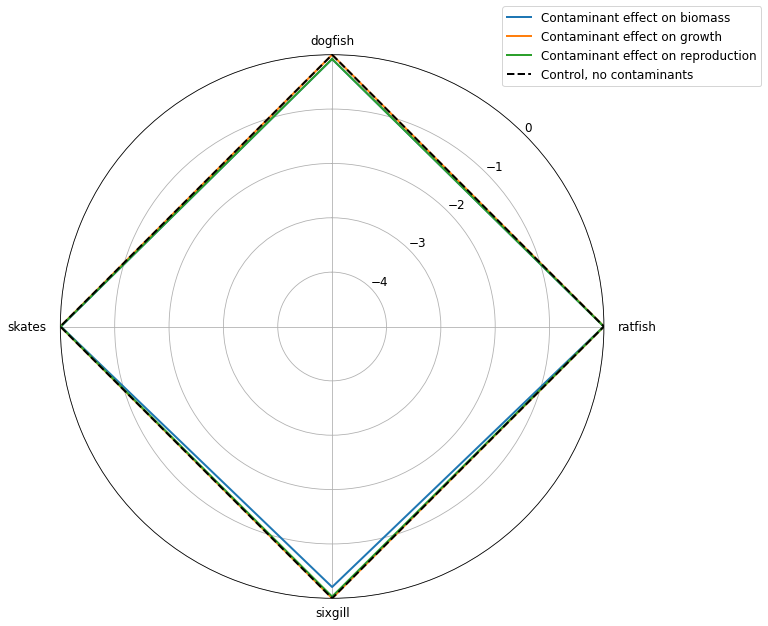

In [148]:
plot_radar_biomass_growth_reprod(groups.sharks, boxes, mean_start, end)

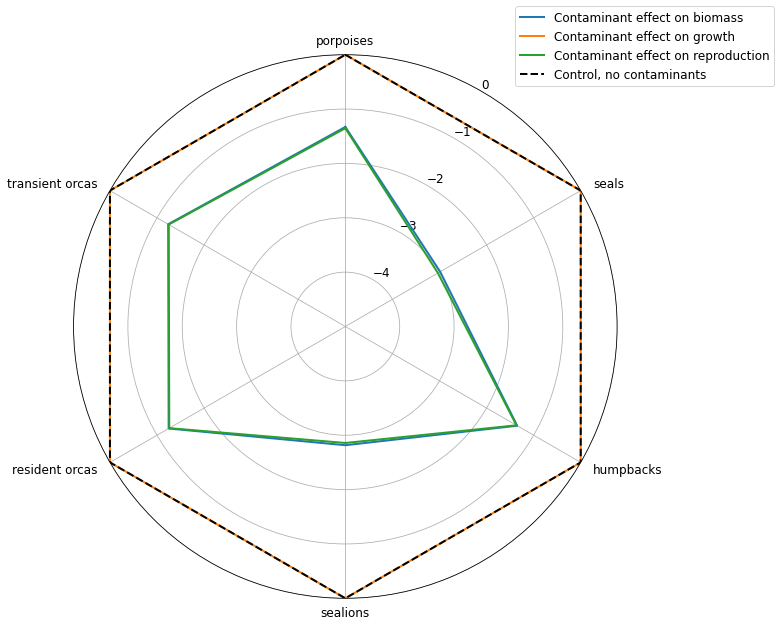

In [147]:
plot_radar_biomass_growth_reprod(groups.mammals, boxes, mean_start, end)